# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

In [8]:
import pandas as pd
import numpy as np 

# regular expression
import re

#os for working with directories an dfiles
import os

#display 
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [9]:
!pip install missingno

In [10]:
#for missing data visualization
import missingno as msno

#sklearn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer

#Librarries for plotting visualizations
import matplotlib.pyplot as plt
import seaborn as sns
#3d plotting
from mpl_toolkits.mplot3d import Axes3D

#warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/kaggletelecomchurncasestudy/data_dictionary.csv
/kaggle/input/kaggletelecomchurncasestudy/sample.csv
/kaggle/input/kaggletelecomchurncasestudy/train.csv
/kaggle/input/kaggletelecomchurncasestudy/test.csv


In [12]:
train = pd.read_csv("/kaggle/input/kaggletelecomchurncasestudy/train.csv")
test = pd.read_csv("/kaggle/input/kaggletelecomchurncasestudy/test.csv")
sample = pd.read_csv("/kaggle/input/kaggletelecomchurncasestudy/sample.csv")
data_dict = pd.read_csv("/kaggle/input/kaggletelecomchurncasestudy/data_dictionary.csv")

print(train.shape)
print(test.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [13]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [14]:
train.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,...,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,145.0,NaN,0.0,352.91,0.00,0.0,3.96,0.0,NaN,122.07,NaN,NaN,122.08,NaN,NaN,0.0,NaN,0,0,0,0,0,0,0,1,0,0,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,0.00,0.0,0.0,0.00,0.0,1.63,6.99,3.94,0.00,37.91,44.89,23.63,0.00,0.00,0.00,0.00,0.00,8.03,44.91,48.84,23.63,0.26,12.06,0.00,15.33,25.93,4.6,0.56,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.0,0.0,15.73,0.0,0.00,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.00,9.85,0.00,58.91,25.94,15.76,0.00,0.00,0.00,4.35,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,7.0,7.0,6.0,25.0,41.0,25.0,7.0,6.0,6.0,0.0,1.0,0.0,175.0,191.0,142.0,390.8,308.89,213.47,0.0,0.00,0.0,0.0,35.00,0.0,0.0,35.12,0.0,0.0,0.0,0.0,0,0,0,7,6,6,0,0,0,0,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [15]:
train.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [16]:
train.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,...,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,...,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,109.0,0.0,0.0,0.0,283.134365,278.185912,278.858826,133.153275,133.894438,132.978257,198.874771,197.153383,196.543577,9.765435,7.014568,7.004892,14.186457,9.842191,9.771783,46.904854,46.166503,45.686109,93.238231,90.799240,91.121447,3.743179,3.777031,3.661652,1.126025,1.361052,1.420840,143.893585,140.750120,140.476486,80.619382,83.775851,83.471486,88.152110,91.538615,90.586999,1.126377,1.084062,1.057739,0.0,0.0,0.0,169.900601,176.401217,175.118852,...,2.467612,2.679989,2.652441,126.500000,126.402071,125.374925,1.865323,2.056311,2.016018,0.602288,0.623678,0.636423,192.831096,201.455940,196.815792,51.773924,51.240204,50.127506,122.171882,128.934444,135.486541,90.069931,89.115767,90.618564,86.863900,85.846074,86.348404,0.025273,0.024069,0.021013,0.079287,0.083401,0.080930,0.388863,0.441406,0.449492,0.075815,0.077730,0.081958,0.075344,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,334.213918,344.366927,351.924315,299.963093,311.277193,311.896596,316.818355,322.482226,324.089234,57.374429,55.960985,53.408135,73.469261,58.511894,64.618388,150.971758,154.739002,153.716880,162.046699,153.852597,152.997805,13.319542,13.568110,13.009193,5.741811,7.914113,6.542202,252.034597,246.313148,245.342359,255.098355,266.693254

# **1. Data Cleaning and Preprocessing**

## Finding columns with number of missing values an dthe percentage of rows with missing values

In [17]:
column_list = []
null_value_list = []
percent_missing= []

for col in train.columns:
    # Check if the column has any null values
    if train[col].isna().sum() > 0:
        column_list.append(col)  # Append column name to the list
        null_value_list.append(train[col].isna().sum())  # Append count of null values to the list
        percent_missing.append((train[col].isna().sum()/train.shape[0])*100) # Append the percentage of null values to the list

# Create a DataFrame from the lists
null_values_df_report = pd.DataFrame({'Column': column_list,'Null Values': null_value_list,'Percent_Missing':percent_missing})

null_values_df_report

,Column,Null Values,Percent_Missing
0,loc_og_t2o_mou,702,1.002871
1,std_og_t2o_mou,702,1.002871
2,loc_ic_t2o_mou,702,1.002871
3,last_date_of_month_7,399,0.570008
4,last_date_of_month_8,733,1.047158
...,...,...,...
120,night_pck_user_7,52134,74.478207
121,night_pck_user_8,51582,73.689624
122,fb_user_6,52431,74.902499
123,fb_user_7,52134,74.478207


<Axes: >

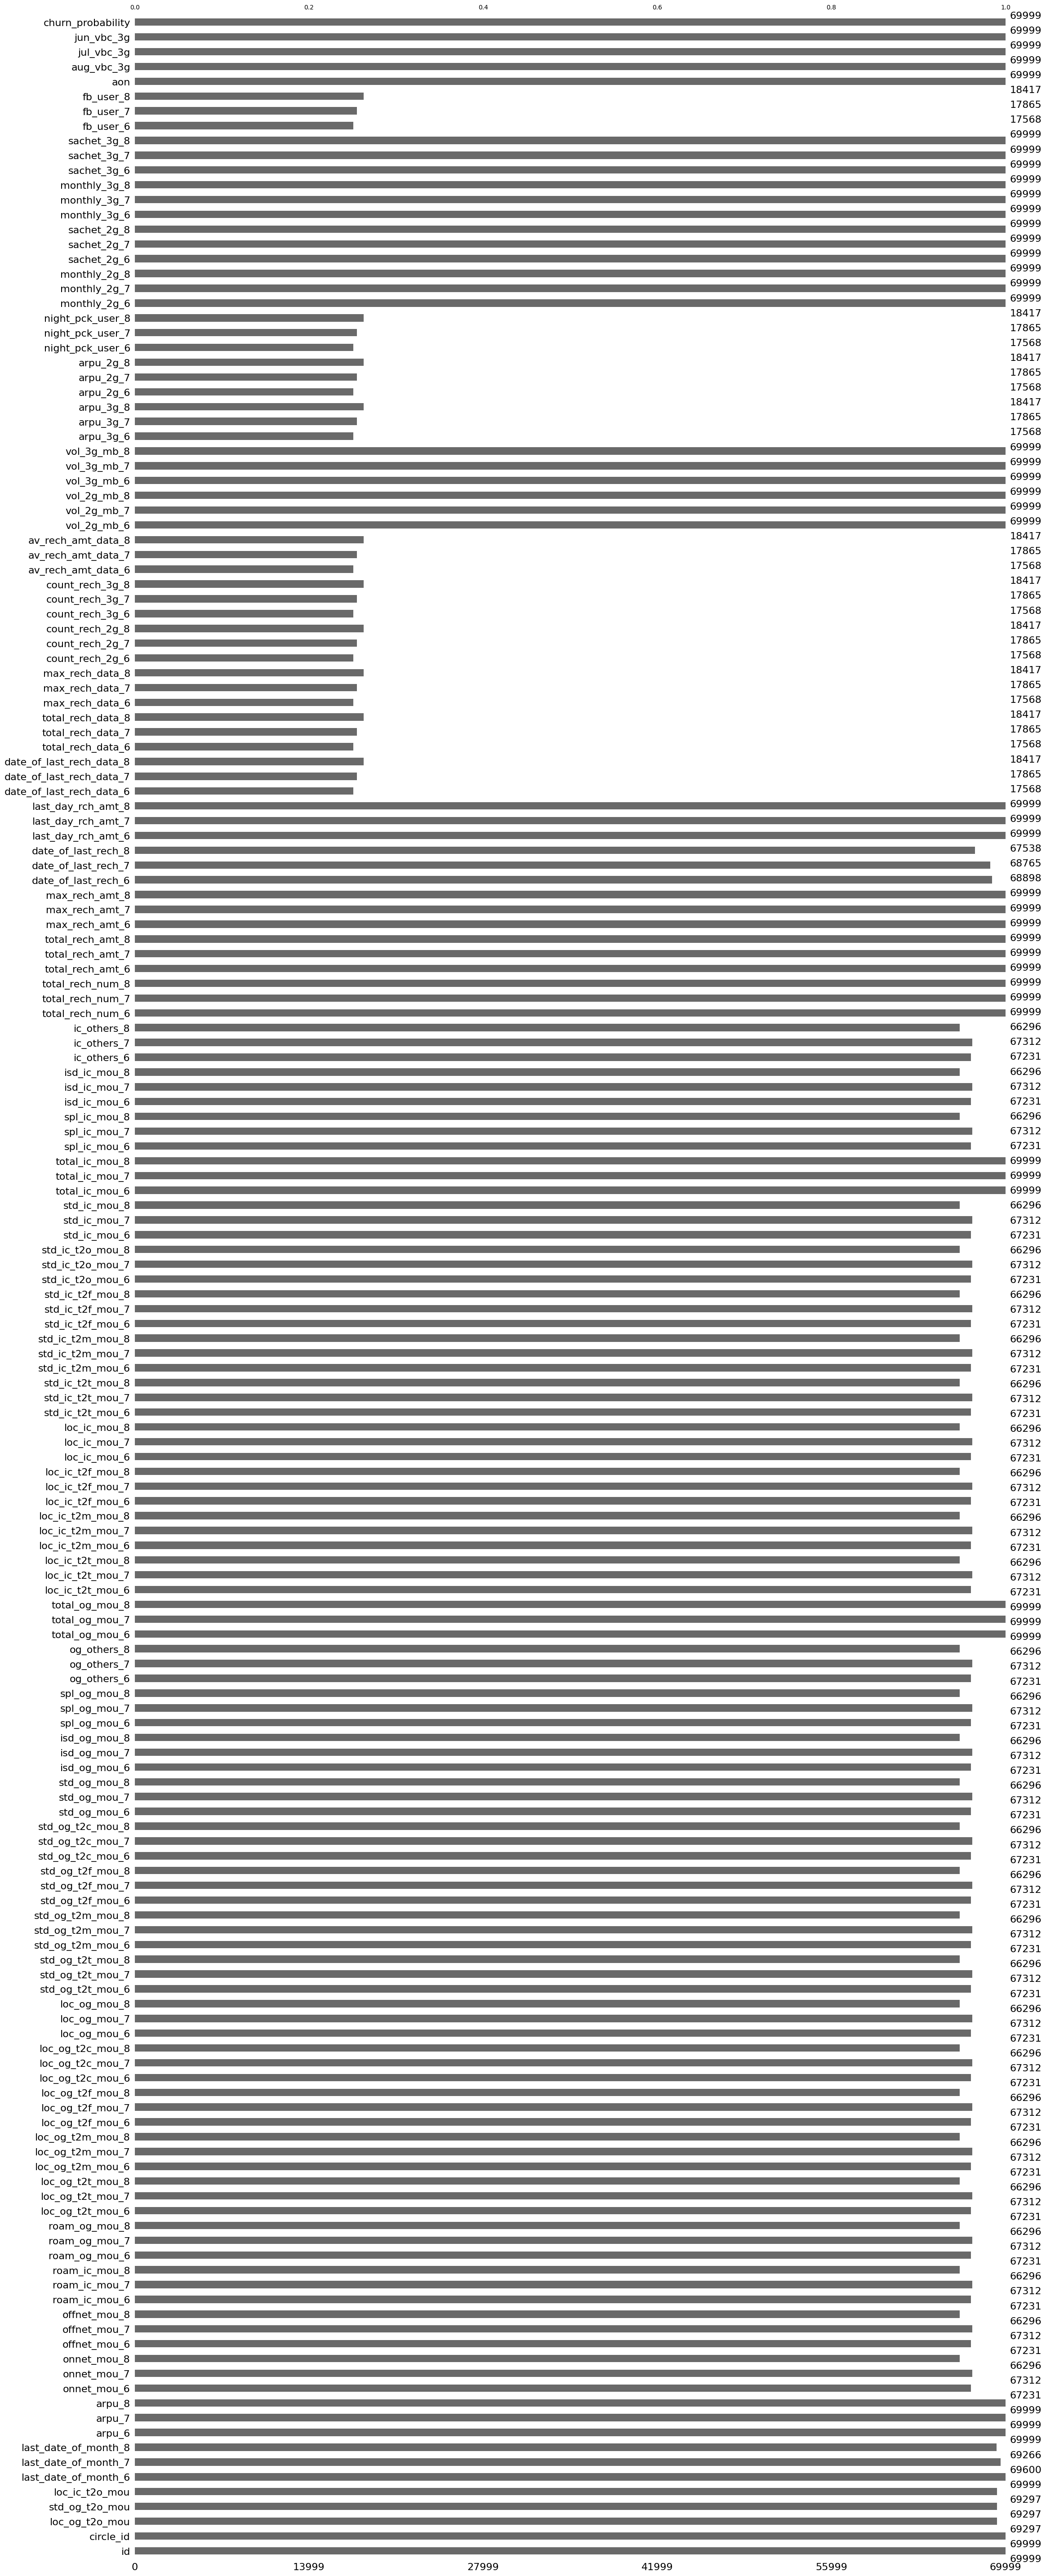

In [18]:
#missingno visualization
msno.bar(train)

<Axes: >

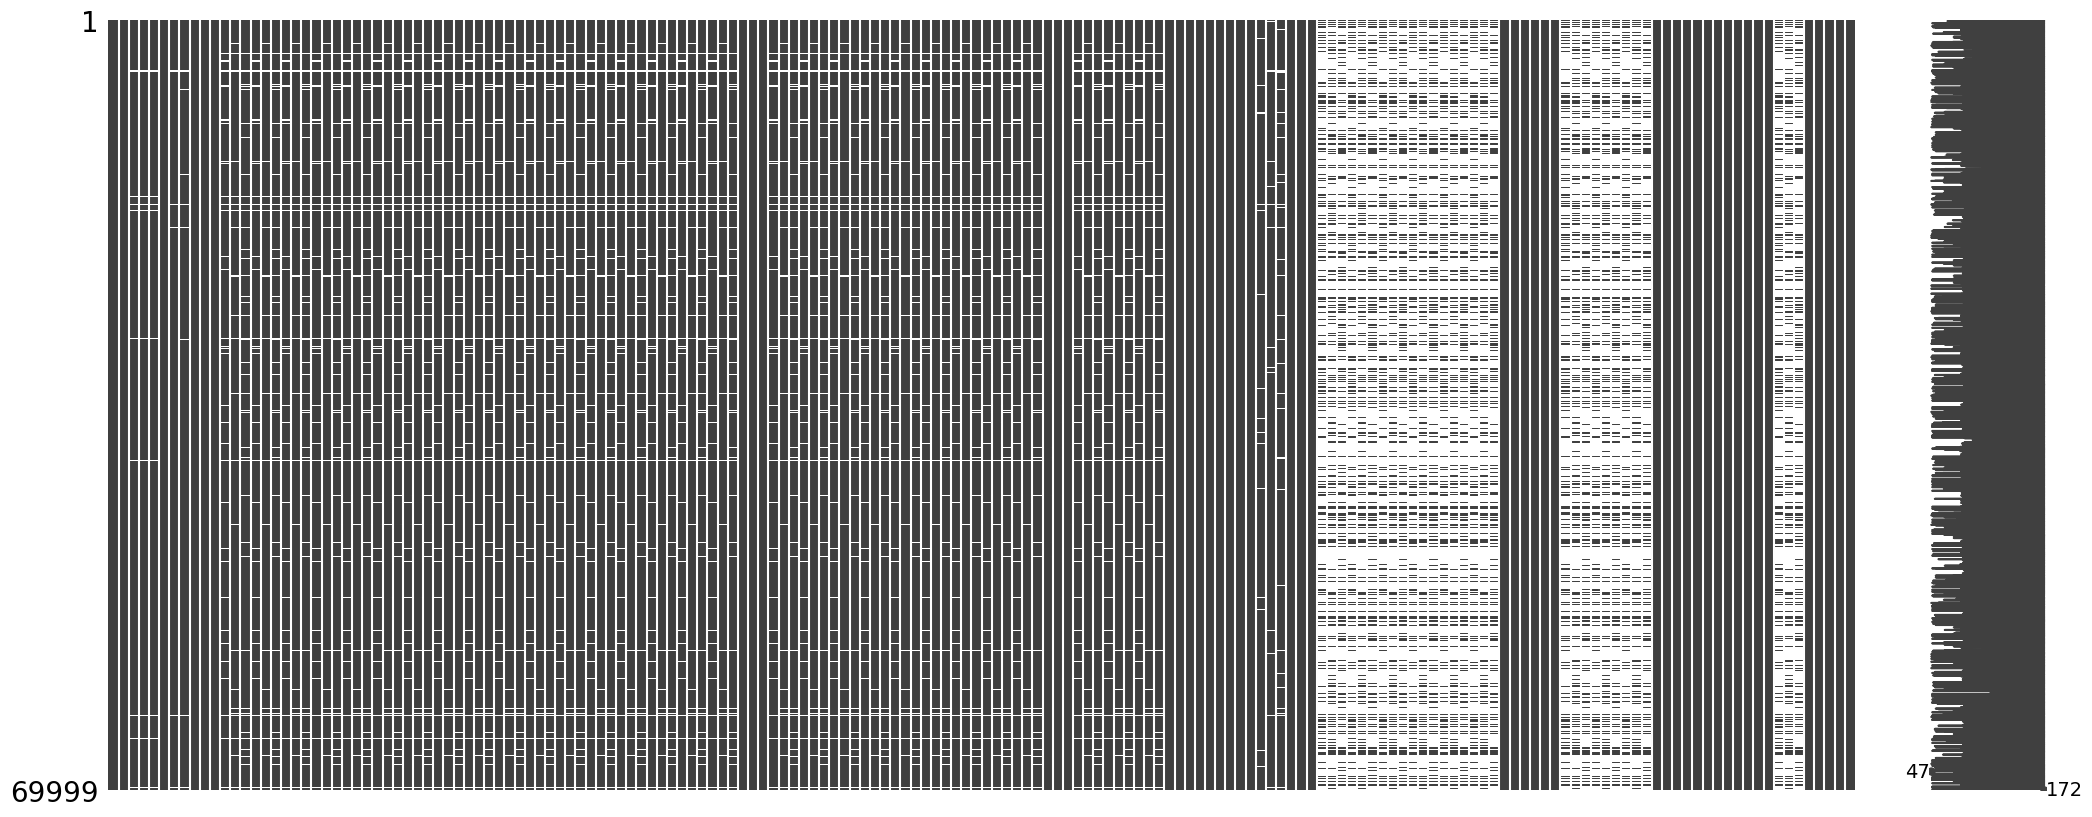

In [19]:
msno.matrix(train)

### Columns with more than 40% of missing values

In [20]:
#null_values_df_report[null_values_df_report['Percent_Missing'] > 40]
init_col_drop = list(null_values_df_report[null_values_df_report['Percent_Missing'] > 40]["Column"])
print(len(init_col_drop))
init_col_drop

30


['date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8']

All these columns which have more than 50% of rows having no data are useless for our model. And in order to reduce the complexity of the model I'll be dropping these columns

In [21]:
#creating a copy of our training dataframe
train_copy = train.copy()

In [22]:
print(f"Number of columns before dropping columns, {train.shape[1]}")
train.drop(columns = init_col_drop,axis = 1, inplace=True)
print(f"Number of columns after dropping columns, {train.shape[1]}")

Number of columns before dropping columns, 172
Number of columns after dropping columns, 142


In [23]:
#updating the nullvalues_df_report
null_values_df_report = null_values_df_report[~null_values_df_report["Column"].isin(init_col_drop)]
#understanding rest of columns with missing values 
null_values_df_report

,Column,Null Values,Percent_Missing
0,loc_og_t2o_mou,702,1.002871
1,std_og_t2o_mou,702,1.002871
2,loc_ic_t2o_mou,702,1.002871
3,last_date_of_month_7,399,0.570008
4,last_date_of_month_8,733,1.047158
5,onnet_mou_6,2768,3.954342
6,onnet_mou_7,2687,3.838626
7,onnet_mou_8,3703,5.290076
8,offnet_mou_6,2768,3.954342
9,offnet_mou_7,2687,3.838626


In [24]:
# column "loc_og_t2o_mou","std_og_t2o_mou","loc_ic_t2o_mou" all have 0's in all of their rows as we can see from df description using .describe() so its safe to drop these three columns too
# Columns last_date_of_month_6, 7, 8 also not influential towards are target feature
train.drop(columns = ["loc_og_t2o_mou","std_og_t2o_mou","loc_ic_t2o_mou","last_date_of_month_6","last_date_of_month_7","last_date_of_month_8"], axis = 1, inplace = True)
print(train.shape)
print(train.columns)

(69999, 136)
Index(['id', 'circle_id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       ...
       'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7',
       'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'churn_probability'],
      dtype='object', length=136)


In [25]:
#updating null_values_df_report
null_values_df_report = null_values_df_report[~null_values_df_report["Column"].isin(["loc_og_t2o_mou","std_og_t2o_mou","loc_ic_t2o_mou"])]
print(null_values_df_report.shape)
print(null_values_df_report.columns)

(92, 3)
Index(['Column', 'Null Values', 'Percent_Missing'], dtype='object')


In [26]:
"""for col in null_values_df_report['Column']:
    if col in train.columns:
        print(col)
        print(train[col].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))
        print("\n")
"""

'for col in null_values_df_report[\'Column\']:\n    if col in train.columns:\n        print(col)\n        print(train[col].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))\n        print("\n")\n'

In [27]:
#specifying numerical and categorical features for proper missing value imputation
num_feat = train.select_dtypes(include=['float64','int64']).columns
cat_feat = train.select_dtypes(include=['object']).columns

#preprocessing pipeline for both numerical and categorical features
num_transformer = SimpleImputer(strategy='mean')
cat_transformer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_feat),
                                              ('cat', cat_transformer, cat_feat)])

#fit and transform
imputed_values = preprocessor.fit_transform(train)
train_imputed_df = pd.DataFrame(imputed_values, columns = num_feat.append(cat_feat))

train_imputed_df.head()

,id,circle_id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,...,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
0,0.0,109.0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.0,0.0,0.0,0.0,0.0,0.0,2.23,0.0,0.28,5.29,16.04,2.33,0.0,0.0,0.0,0.0,0.0,0.0,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,...,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.0,3.0,2.0,2.0,77.0,65.0,10.0,65.0,65.0,10.0,65.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1958.0,0.0,0.0,0.0,0.0,6/22/2014,7/10/2014,8/24/2014
1,1.0,109.0,0.0,122.787,42.953,0.0,0.0,0.0,0.0,25.99,30.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.01,29.79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,5.0,0.0,145.0,50.0,0.0,145.0,50.0,0.0,0.0,0.0,0.0,352.91,0.0,0.0,3.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,710.0,0.0,0.0,0.0,0.0,6/12/2014,7/10/2014,8/26/2014
2,2.0,109.0,60.806,103.176,0.0,0.53,15.93,0.0,53.99,82.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.53,12.98,0.0,24.11,0.0,0.0,0.0,0.0,0.0,2.14,0.0,0.0,24.64,12.98,0.0,0.0,2.94,0.0,28.94,82.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.94,84.99,0.0,0.0,0.0,0.0,...,124.29,33.83,36.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,2.0,4.0,2.0,70.0,120.0,0.0,70.0,70.0,0.0,70.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,882.0,0.0,0.0,0.0,0.0,6/11/2014,7/22/2014,8/24/2014
3,3.0,109.0,156.362,205.26,111.095,7.26,16.01,0.0,68.76,78.48,50.23,0.0,0.0,0.0,0.0,0.0,1.63,6.99,3.94,0.0,37.91,44.89,23.63,0.0,0.0,0.0,0.0,0.0,8.03,44.91,48.84,23.63,0.26,12.06,0.0,15.33,25.93,4.6,0.56,0.0,0.0,0.0,0.0,0.0,16.16,37.99,4.6,0.0,0.0,0.0,...,95.11,50.18,83.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,3.0,160.0,240.0,130.0,110.0,110.0,50.0,110.0,110.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,982.0,0.0,0.0,0.0,0.0,6/15/2014,7/21/2014,8/25/2014
4,4.0,109.0,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.0,0.0,15.73,0.0,0.0,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.0,9.85,0.0,58.91,25.94,15.76,0.0,0.0,0.0,4.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.35,0.0,0.0,0.0,0.0,0.0,...,21.54,9.36,28.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,10.0,8.0,290.0,136.0,122.0,50.0,41.0,30.0,25.0,10.0,30.0,390.8,308.89,213.47,0.0,0.0,0.0,0.0,0.0,0.0,7.0,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,647.0,0.0,0.0,0.0,0.0,6/25/2014,7/26/2014,8/30/2014


In [28]:
for col in train_imputed_df:
    print(f"{col} has {train_imputed_df[col].isnull().sum()} missing values after imputation")

id has 0 missing values after imputation
circle_id has 0 missing values after imputation
arpu_6 has 0 missing values after imputation
arpu_7 has 0 missing values after imputation
arpu_8 has 0 missing values after imputation
onnet_mou_6 has 0 missing values after imputation
onnet_mou_7 has 0 missing values after imputation
onnet_mou_8 has 0 missing values after imputation
offnet_mou_6 has 0 missing values after imputation
offnet_mou_7 has 0 missing values after imputation
offnet_mou_8 has 0 missing values after imputation
roam_ic_mou_6 has 0 missing values after imputation
roam_ic_mou_7 has 0 missing values after imputation
roam_ic_mou_8 has 0 missing values after imputation
roam_og_mou_6 has 0 missing values after imputation
roam_og_mou_7 has 0 missing values after imputation
roam_og_mou_8 has 0 missing values after imputation
loc_og_t2t_mou_6 has 0 missing values after imputation
loc_og_t2t_mou_7 has 0 missing values after imputation
loc_og_t2t_mou_8 has 0 missing values after imputat

In [29]:
#after imputing values all the features are of type object, assigning them their orignal type
mask = train.columns.isin(train_imputed_df.columns)
train_subset = train[train.columns[mask]]
train_imputed_df = train_imputed_df.astype(train_subset.dtypes)


In [30]:
train_imputed_df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 136 columns):
 #    Column               Dtype  
---   ------               -----  
 0    id                   int64  
 1    circle_id            int64  
 2    arpu_6               float64
 3    arpu_7               float64
 4    arpu_8               float64
 5    onnet_mou_6          float64
 6    onnet_mou_7          float64
 7    onnet_mou_8          float64
 8    offnet_mou_6         float64
 9    offnet_mou_7         float64
 10   offnet_mou_8         float64
 11   roam_ic_mou_6        float64
 12   roam_ic_mou_7        float64
 13   roam_ic_mou_8        float64
 14   roam_og_mou_6        float64
 15   roam_og_mou_7        float64
 16   roam_og_mou_8        float64
 17   loc_og_t2t_mou_6     float64
 18   loc_og_t2t_mou_7     float64
 19   loc_og_t2t_mou_8     float64
 20   loc_og_t2m_mou_6     float64
 21   loc_og_t2m_mou_7     float64
 22   loc_og_t2m_mou_8     float64
 23   loc_og_t2

# Understanding behaviour of High Valued Customer

In [31]:
# High value customers: Are those customers which have spent more than or equal to X, where X can be taken as 70% percentile 
# of the average amount spent in their first two months ( which  is the good phase )

#A very logical way to get an average amount spent on recharges by the customers cna be derived from 
#"av_rech_amt_data_x" and "total_rech_data_x" (where, x is the moth which is 6,7 or 8)

#However on both these columns have more than 70% data missing in these columns
#Finally a good way to identify high-valued customers can be sort using column "total_rech_amt_x" (where, x is the moth which is 6,7 or 8)

#I had two more columns to get an idea about the data which are 

#Firsty, "max_rech_amt_x" which is the maximum/highest amount of recharge made by the customer in the month of X, however there is a 
#possibility that there could bbe several other recharges which could be less than this amount.

# Second is the "total_rech_num_x", which is the total number of recharges made by the user, analyzing this further proved my base hypothesis true.

* Lets find out the tortal amount of recharge made by customers in the good phase i.e in the month of June and july

In [32]:
#total recharge amuont spent in the month of 6 and 7
train_imputed_df['total_rech_amt_6n7'] = train_imputed_df['total_rech_amt_6'] + train_imputed_df['total_rech_amt_7']

#taking the 70% percentile of the calculated amount
perc_70_6n7 = np.percentile(train_imputed_df['total_rech_amt_6n7'], 70.0)
print(f"70 percentile is : {perc_70_6n7}")

70 percentile is : 740.0


In [33]:
train_imputed_df['total_rech_amt_6n7'].describe()

count    69999.000000
mean       650.516150
std        752.345306
min          0.000000
25%        230.000000
50%        458.000000
75%        839.500000
max      75525.000000
Name: total_rech_amt_6n7, dtype: float64

In [34]:
# I'm dropping the original columns in order to reduce multi-collinearity for future
train_imputed_df.drop(columns=["total_rech_amt_6","total_rech_amt_7"], axis=1, inplace=True)

In [35]:
#filtering high-valued customer
train_hv_customer = train_imputed_df[train_imputed_df['total_rech_amt_6n7'] >= perc_70_6n7]
print("Dimensions of the filtered dataset:",train_hv_customer.shape)

Dimensions of the filtered dataset: (21018, 135)


In [36]:
churn_yes = train_hv_customer["churn_probability"].value_counts()[1]
churn_no = train_hv_customer["churn_probability"].value_counts()[0]
print(f"Number of high value customer that will churn {churn_yes}\n")
print(f"Number of high value customer that won't churn {churn_no}")

Number of high value customer that will churn 1859

Number of high value customer that won't churn 19159


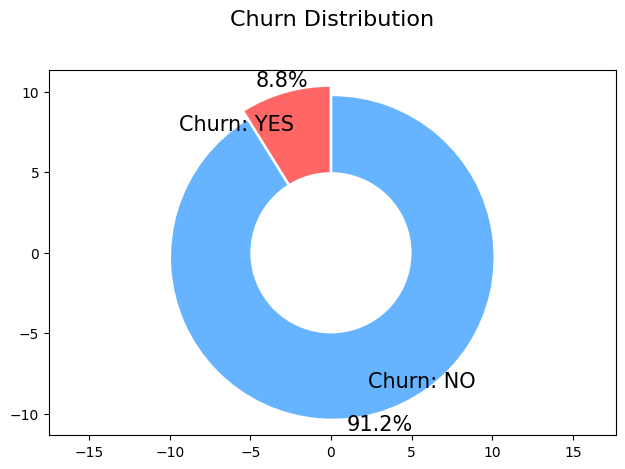

In [37]:

labels = ["Churn: YES", "Churn: NO"]
values = [churn_yes, churn_no]
colors = ["#ff6666", "#66b3ff"]
explode = (0.3,0.3)
textprops = {"fontsize":15}
#Plotting the piechart
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True)


#drawing circle
centre_circle = plt.Circle((0,0),5,color='black',fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Churn Distribution", fontsize = 16, y=1.1)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [38]:
train_hv_customer.columns

Index(['id', 'circle_id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       ...
       'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'churn_probability', 'date_of_last_rech_6', 'date_of_last_rech_7',
       'date_of_last_rech_8', 'total_rech_amt_6n7'],
      dtype='object', length=135)

In [39]:
# looking for columns with least variance for the high-value custiomers df
for col in train_hv_customer.columns:
    if train_hv_customer[col].nunique() == 1:
        print(f"Column : {col} has least variance , since it only contains only {train_hv_customer[col].nunique()} unique values")
        print(f"* log : Dropping column {col} ")
        train_hv_customer.drop(col, axis=1, inplace=True)
        
print(f"Updates train_hv_customer dataframe, number of columns are {train_hv_customer.shape[1]}")

Column : circle_id has least variance , since it only contains only 1 unique values
* log : Dropping column circle_id 
Column : std_og_t2c_mou_6 has least variance , since it only contains only 1 unique values
* log : Dropping column std_og_t2c_mou_6 
Column : std_og_t2c_mou_7 has least variance , since it only contains only 1 unique values
* log : Dropping column std_og_t2c_mou_7 
Column : std_og_t2c_mou_8 has least variance , since it only contains only 1 unique values
* log : Dropping column std_og_t2c_mou_8 
Column : std_ic_t2o_mou_6 has least variance , since it only contains only 1 unique values
* log : Dropping column std_ic_t2o_mou_6 
Column : std_ic_t2o_mou_7 has least variance , since it only contains only 1 unique values
* log : Dropping column std_ic_t2o_mou_7 
Column : std_ic_t2o_mou_8 has least variance , since it only contains only 1 unique values
* log : Dropping column std_ic_t2o_mou_8 
Updates train_hv_customer dataframe, number of columns are 128


In [40]:
(train_hv_customer.isnull().sum()/len(train_hv_customer)).sort_values(ascending=False)

id                    0.0
arpu_6                0.0
total_rech_amt_8      0.0
total_rech_num_8      0.0
total_rech_num_7      0.0
                     ... 
std_og_t2f_mou_6      0.0
std_og_t2m_mou_8      0.0
std_og_t2m_mou_7      0.0
std_og_t2m_mou_6      0.0
total_rech_amt_6n7    0.0
Length: 128, dtype: float64

In [41]:
train_hv_customer.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,...,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,total_rech_amt_6n7
12,12,439.919,397.946,392.024,244.46,108.31,42.98,571.98,727.91,644.43,0.0,0.0,0.0,0.0,0.0,0.0,0.00,7.86,3.98,44.01,13.93,51.24,0.00,0.00,0.00,0.0,0.0,0.00,44.01,21.79,55.23,244.46,100.44,38.99,527.96,713.98,593.18,0.0,0.0,0.00,772.43,814.43,632.18,0.0,0.0,0.0,0.00,0.00,0.00,0.0,...,2.46,34.49,35.34,26.99,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,15,10,20,365,110,110,50,110,0,0,0.00,0.0,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,322,0.0,0.0,0.0,0,6/29/2014,7/30/2014,8/30/2014,939
15,15,580.549,377.294,338.286,10.43,24.99,194.43,317.11,341.79,197.09,0.0,0.0,0.0,0.0,0.0,0.0,10.43,24.99,194.43,313.76,330.88,185.88,3.26,10.91,4.94,0.0,0.0,0.00,327.46,366.79,385.26,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,6.26,0.00,0.00,6.26,0.0,0.0,0.0,0.08,0.00,0.00,0.1,...,0.00,233.18,777.39,629.94,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,5,3,4,652,250,250,250,0,150,250,260.42,0.0,354.35,0.0,0.0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,602,0.0,0.0,0.0,0,6/27/2014,7/25/2014,8/30/2014,1054
23,23,1130.948,905.506,479.762,859.53,372.71,0.89,293.46,450.11,386.91,0.0,0.0,0.0,0.0,0.0,0.0,859.53,372.71,0.89,79.79,424.63,378.01,11.58,25.43,8.88,0.0,0.0,0.00,950.91,822.78,387.79,0.00,0.00,0.00,202.08,0.00,0.00,0.0,0.0,0.00,202.08,0.00,0.00,0.0,0.0,0.0,0.00,0.05,0.01,0.0,...,0.00,598.54,448.36,203.29,0.13,0.0,0.0,0.00,0.00,0.00,0.0,0.15,0.4,26,19,10,494,110,110,144,110,50,30,0.00,0.0,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,455,0.0,0.0,0.0,0,6/30/2014,7/31/2014,8/22/2014,2410
24,24,371.974,352.069,240.449,93.18,38.29,29.86,531.19,507.76,222.03,0.0,0.0,0.0,0.0,0.0,0.0,93.18,38.29,29.86,159.29,219.44,99.86,0.00,0.00,0.00,0.0,0.0,0.36,252.48,257.74,129.73,0.00,0.00,0.00,371.89,288.31,121.79,0.0,0.0,0.00,371.89,288.31,121.79,0.0,0.0,0.0,0.00,0.00,0.36,0.0,...,21.93,230.08,155.64,192.94,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,7,7,10,240,110,110,30,110,0,30,0.04,0.0,0.00,0.0,0.0,0.0,0,0,0,1,2,1,0,0,0,0,0,0,1219,0.0,0.0,0.0,0,6/24/2014,7/25/2014,8/30/2014,867
25,25,362.951,321.763,689.603,193.71,124.53,197.54,423.21,184.88,556.61,0.0,0.0,0.0,0.0,0.0,0.0,49.81,75.01,81.86,164.39,115.48,229.68,3.31,0.00,0.36,0.0,0.0,7.01,217.53,190.49,311.91,143.89,49.51,115.68,255.49,64.99,301.31,0.0,0.0,0.00,399.39,114.51,416.99,0.0,0.0,0.0,0.00,4.40,25.24,0.0,...,10.04,401.39,319.08,454.91,0.00,0.0,0.0,4.01,2.28,19.28,0.0,0.00,0.0,8,5,11,730,110,150,130,110,150,50,0.00,0.0,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,2831,0.0,0.0,0.0,0,6/22/2014,7/29/2014,8/30/2014,810


In [42]:
# looking for columns with least variance for the main train imputed data df
for col in train_imputed_df.columns:
    if train_imputed_df[col].nunique() == 1:
        print(f"Column : {col} has least variance , since it only contains only {train_imputed_df[col].nunique()} unique values")
        print(f"* log : Dropping column {col} ")
        train_imputed_df.drop(col, axis=1, inplace=True)
        
print(f"Updates train_hv_customer dataframe, number of columns are {train_imputed_df.shape[1]}")

Column : circle_id has least variance , since it only contains only 1 unique values
* log : Dropping column circle_id 
Column : std_og_t2c_mou_6 has least variance , since it only contains only 1 unique values
* log : Dropping column std_og_t2c_mou_6 
Column : std_og_t2c_mou_7 has least variance , since it only contains only 1 unique values
* log : Dropping column std_og_t2c_mou_7 
Column : std_og_t2c_mou_8 has least variance , since it only contains only 1 unique values
* log : Dropping column std_og_t2c_mou_8 
Column : std_ic_t2o_mou_6 has least variance , since it only contains only 1 unique values
* log : Dropping column std_ic_t2o_mou_6 
Column : std_ic_t2o_mou_7 has least variance , since it only contains only 1 unique values
* log : Dropping column std_ic_t2o_mou_7 
Column : std_ic_t2o_mou_8 has least variance , since it only contains only 1 unique values
* log : Dropping column std_ic_t2o_mou_8 
Updates train_hv_customer dataframe, number of columns are 128


In [43]:
#since we have age on network we dont ned the last date of recharge column for all thre months
#updating data for high-value customers
temp_col_list = ["date_of_last_rech_6","date_of_last_rech_7","date_of_last_rech_8"]
print(f"Number of columns before dropping: {train_hv_customer.shape[1]}")
train_hv_customer.drop(temp_col_list, axis = 1, inplace=True)
print(f"Number of columns after dropping: {train_hv_customer.shape[1]}")

Number of columns before dropping: 128
Number of columns after dropping: 125


In [44]:
#updating data for the full train dataset
print(f"Number of columns before dropping: {train_imputed_df.shape[1]}")
train_imputed_df.drop(temp_col_list, axis = 1, inplace=True)
print(f"Number of columns after dropping: {train_imputed_df.shape[1]}")

Number of columns before dropping: 128
Number of columns after dropping: 125


In [45]:
corr_matrix = train_hv_customer.corr()
churn_corr = corr_matrix["churn_probability"]
churn_corr_df = pd.DataFrame({"Columns": train_hv_customer.columns,
                           "Correlation": churn_corr})
#resetting the index
churn_corr_df.reset_index(drop=True, inplace=True)
churn_corr_df.sort_values(by="Correlation", ascending=False)

,Columns,Correlation
123,churn_probability,1.000000
40,std_og_mou_6,0.144492
31,std_og_t2t_mou_6,0.108329
34,std_og_t2m_mou_6,0.104773
14,roam_og_mou_7,0.089443
...,...,...
93,total_rech_num_8,-0.156841
94,total_rech_amt_8,-0.177027
54,total_og_mou_8,-0.177829
3,arpu_8,-0.178090


In [46]:
churn_corr_df

,Columns,Correlation
0,id,-0.006994
1,arpu_6,0.058825
2,arpu_7,-0.030851
3,arpu_8,-0.178090
4,onnet_mou_6,0.084223
...,...,...
120,aug_vbc_3g,-0.075830
121,jul_vbc_3g,-0.049119
122,jun_vbc_3g,-0.028925
123,churn_probability,1.000000


<Axes: >

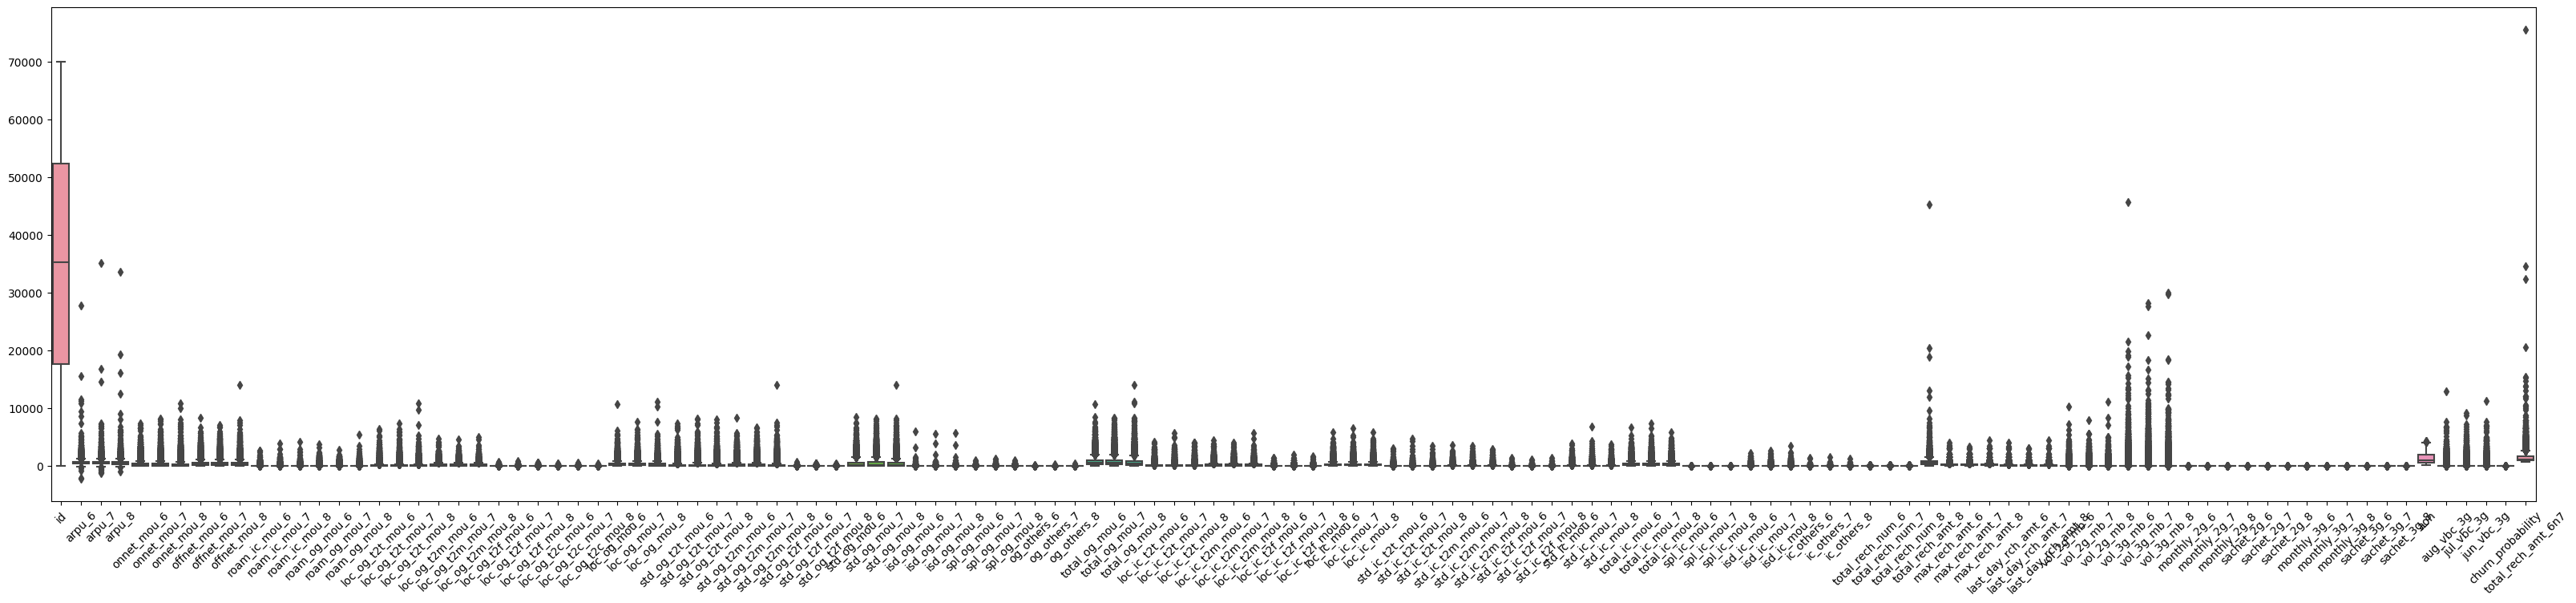

In [47]:
plt.figure(figsize=(40,8))
plt.xticks(rotation=45)
sns.boxplot(data = train_hv_customer)

# Exploratory Data Analysis

### EDA on main train set, we will be using train_imputed_df

In [48]:
train_imputed_df["comb_rev_per_user"] = train_imputed_df["arpu_6"]+train_imputed_df["arpu_7"]+train_imputed_df["arpu_8"]
train_imputed_df.drop(['arpu_6','arpu_7',"arpu_8"], axis = 1, inplace=True)

In [49]:
train_imputed_df["minute_incoming_roaming_calls"] = train_imputed_df["roam_ic_mou_6"] + train_imputed_df["roam_ic_mou_7"] + train_imputed_df["roam_ic_mou_8"]
train_imputed_df.drop(["roam_ic_mou_6","roam_ic_mou_7","roam_ic_mou_8"], axis = 1, inplace = True)

In [50]:
train_imputed_df["minute_outgoing_roaming_calls"] = train_imputed_df["roam_og_mou_6"] +train_imputed_df["roam_og_mou_7"] +train_imputed_df["roam_og_mou_8"]
train_imputed_df.drop(["roam_og_mou_6","roam_og_mou_7","roam_og_mou_8"], axis = 1, inplace = True)

In [51]:
train_imputed_df["duration_same_network_calls"] = train_imputed_df["onnet_mou_6"] +train_imputed_df["onnet_mou_7"] + train_imputed_df["onnet_mou_8"]
train_imputed_df.drop(["onnet_mou_6","onnet_mou_7","onnet_mou_8"], axis = 1, inplace = True)

In [52]:
train_imputed_df["duration_other_network_calls"] = train_imputed_df["offnet_mou_6"] +train_imputed_df["offnet_mou_7"] + train_imputed_df["offnet_mou_8"]
train_imputed_df.drop(["offnet_mou_6","offnet_mou_7","offnet_mou_8"], axis = 1, inplace = True)

In [53]:
train_imputed_df["postpaid_user_3G"] = train_imputed_df["aug_vbc_3g"] + train_imputed_df["jul_vbc_3g"] + train_imputed_df["jun_vbc_3g"]
train_imputed_df.drop(["aug_vbc_3g","jul_vbc_3g","jun_vbc_3g"], axis=1, inplace=True)

In [54]:
train_imputed_df["total_rech_amt"] = train["total_rech_amt_6"] + train["total_rech_amt_7"] +train["total_rech_amt_8"]
train_imputed_df.drop(["total_rech_amt_8"], axis = 1, inplace = True)

In [55]:
train_imputed_df["total_duration_outgoing_calls"] = train_imputed_df["total_og_mou_6"] + train_imputed_df["total_og_mou_7"] + train_imputed_df["total_og_mou_8"]
train_imputed_df.drop(["total_og_mou_6","total_og_mou_7","total_og_mou_8"], axis = 1, inplace = True)

In [56]:
train_imputed_df["total_intenet_used_mb_3G"] = train_imputed_df["vol_3g_mb_6"] + train_imputed_df["vol_3g_mb_7"] + train_imputed_df["vol_3g_mb_8"]
train_imputed_df.drop(["vol_3g_mb_6","vol_3g_mb_7","vol_3g_mb_8"], axis = 1 , inplace=True)

In [57]:
train_imputed_df['total_internet_used_mb_2G'] = train_imputed_df['vol_2g_mb_6'] + train_imputed_df['vol_2g_mb_7'] + train_imputed_df['vol_2g_mb_8']
train_imputed_df.drop(['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8'], axis = 1, inplace = True)

# Splitting High-value Customer data to X and Y variables

In [58]:
#splitting the train_hv_customer dataset
X = train_imputed_df.drop("churn_probability",axis = 1)
y = train_imputed_df.churn_probability

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48999, 106), (21000, 106), (48999,), (21000,))

In [60]:
X_train.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 48999 entries, 61787 to 15795
Data columns (total 106 columns):
 #    Column                         Dtype  
---   ------                         -----  
 0    id                             int64  
 1    loc_og_t2t_mou_6               float64
 2    loc_og_t2t_mou_7               float64
 3    loc_og_t2t_mou_8               float64
 4    loc_og_t2m_mou_6               float64
 5    loc_og_t2m_mou_7               float64
 6    loc_og_t2m_mou_8               float64
 7    loc_og_t2f_mou_6               float64
 8    loc_og_t2f_mou_7               float64
 9    loc_og_t2f_mou_8               float64
 10   loc_og_t2c_mou_6               float64
 11   loc_og_t2c_mou_7               float64
 12   loc_og_t2c_mou_8               float64
 13   loc_og_mou_6                   float64
 14   loc_og_mou_7                   float64
 15   loc_og_mou_8                   float64
 16   std_og_t2t_mou_6               float64
 17   std_og_t2t_mou_7              

# Feature Selection

## Feature selection using RFE

In [61]:
model = LogisticRegression()
rfe = RFE(model, n_features_to_select = 20)
fit = rfe.fit(X_train, y_train)
selected_features_rfe = X_train.columns[rfe.support_]

### Most influencial features as per RFE

In [62]:
selected_features_rfe

Index(['loc_og_t2c_mou_7', 'loc_og_mou_6', 'std_og_mou_6', 'std_og_mou_7',
       'isd_og_mou_6', 'spl_og_mou_8', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_7',
       'std_ic_t2f_mou_7', 'std_ic_mou_7', 'total_ic_mou_7', 'total_ic_mou_8',
       'isd_ic_mou_7', 'isd_ic_mou_8', 'total_rech_num_6', 'total_rech_num_7',
       'total_rech_num_8', 'last_day_rch_amt_8', 'sachet_2g_8',
       'total_duration_outgoing_calls'],
      dtype='object')

## Feature Selection using XGBoost

In [63]:
from xgboost import plot_importance
from xgboost import XGBClassifier

In [64]:
# for classifying featurinf in our dataframe
model_xgb = XGBClassifier() 

model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [65]:
#identifying importance of features
score = model_xgb.feature_importances_

feature_scores_df = pd.DataFrame({'Features':X_train.columns, "Scores":score})
feature_scores_df = feature_scores_df.sort_values(by="Scores", ascending = False)

In [66]:
feature_scores_df

,Features,Scores
63,total_ic_mou_8,0.330446
48,loc_ic_mou_8,0.030297
66,spl_ic_mou_8,0.024202
98,minute_outgoing_roaming_calls,0.018817
78,max_rech_amt_8,0.018513
...,...,...
36,og_others_8,0.003064
31,spl_og_mou_6,0.002776
88,monthly_3g_6,0.001803
82,monthly_2g_6,0.001411


In [67]:
#Selecting top n features , here n is 20 but you can choose it as per your liking
n = 20

top_n_feat = feature_scores_df.head(n)['Features']

### Most influencial features as per XGBoost Classifier

In [68]:
top_n_feat

63                    total_ic_mou_8
48                      loc_ic_mou_8
66                      spl_ic_mou_8
98     minute_outgoing_roaming_calls
78                    max_rech_amt_8
81                last_day_rch_amt_8
72                       ic_others_8
104         total_intenet_used_mb_3G
84                      monthly_2g_8
74                  total_rech_num_7
42                  loc_ic_t2m_mou_8
90                      monthly_3g_8
30                      isd_og_mou_8
15                      loc_og_mou_8
25                      std_og_mou_6
62                    total_ic_mou_7
69                      isd_ic_mou_8
47                      loc_ic_mou_7
87                       sachet_2g_8
97     minute_incoming_roaming_calls
Name: Features, dtype: object

# Age on Network Visualization

# High Value Customer

In [69]:
train_hv_customer["aon"].describe()

count    21018.000000
mean      1267.746027
std        973.120981
min        180.000000
25%        480.000000
50%        926.000000
75%       1941.750000
max       4321.000000
Name: aon, dtype: float64

### Analysis

All the **high paying customers** have a tenure of around `500` to `2000` days

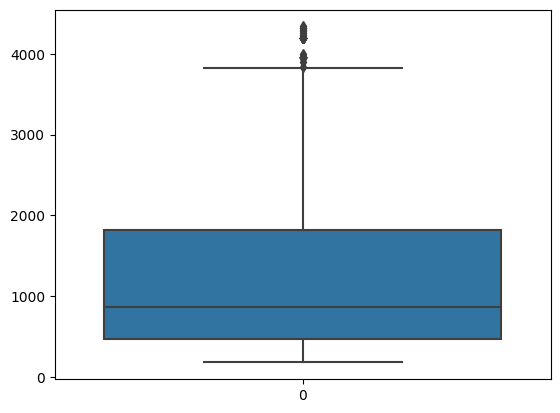

In [70]:
# overall distribution for age on network'
sns.boxplot(train_imputed_df["aon"])
plt.show()


Text(0.5, 1.0, 'Tenure Graph')

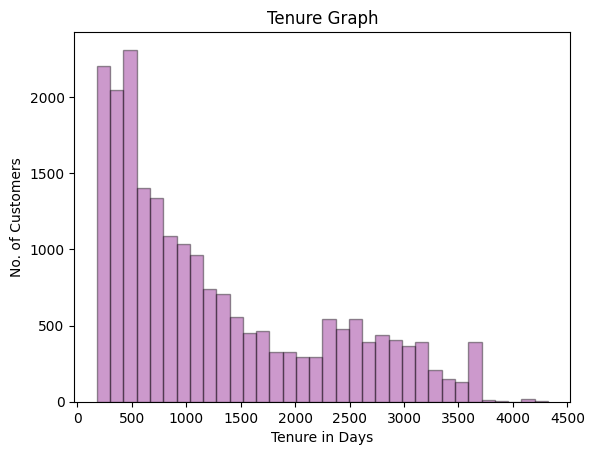

In [71]:
sns.distplot(train_hv_customer["aon"], hist = True, kde=False,
             color='purple', bins = int(170/5),
             hist_kws={'edgecolor':'black'}, kde_kws={"linewidth": 10})
plt.xticks(range(0, 5000, 500))
plt.ylabel("No. of Customers")
plt.xlabel('Tenure in Days')
plt.title('Tenure Graph')



<Axes: >

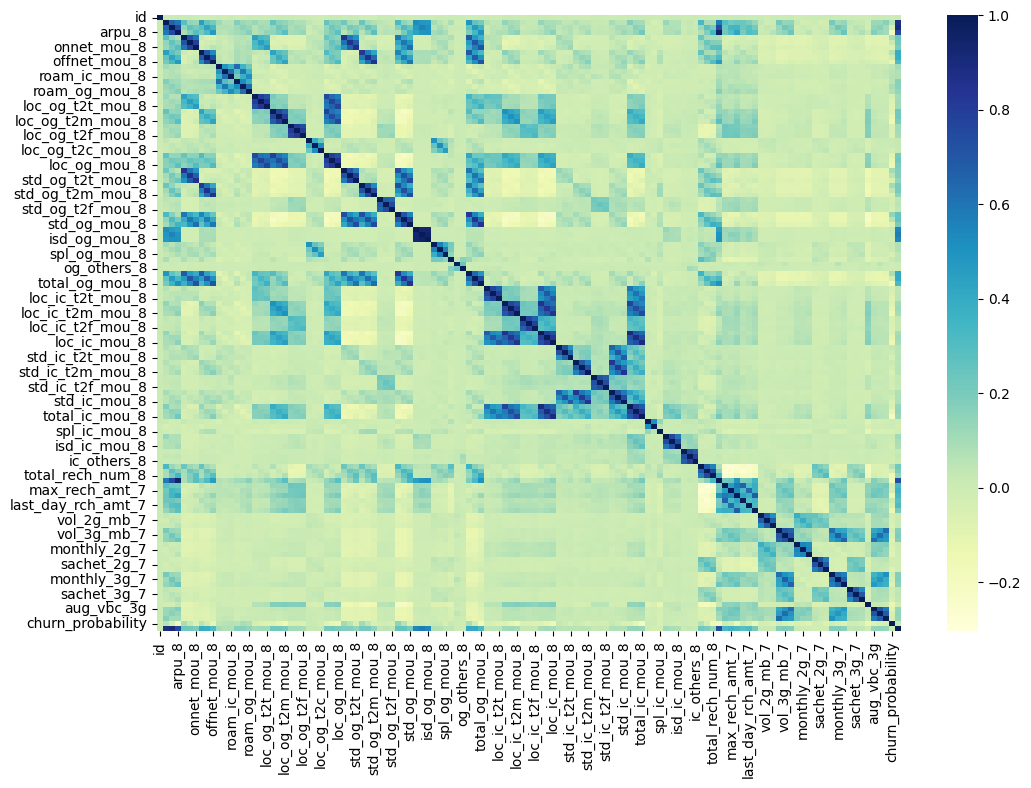

In [72]:
# visualizaing a heatmap
plt.figure(figsize=(12,8))
sns.heatmap(train_hv_customer.corr(), cmap="YlGnBu")

## Duration of Incomming Roaming Calls (Minutes)

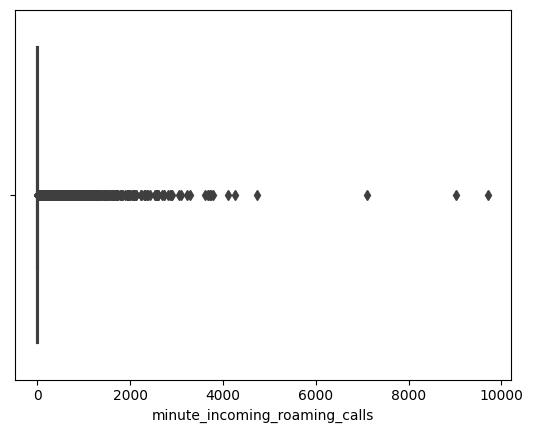

In [73]:
sns.boxplot(data = train_imputed_df, x = "minute_incoming_roaming_calls")
plt.show()

In [74]:
train_imputed_df["aon_category"] = pd.qcut(train_imputed_df["aon"], q=4, labels = ["0-1000","1000-2000","2000-3000","3000+"])

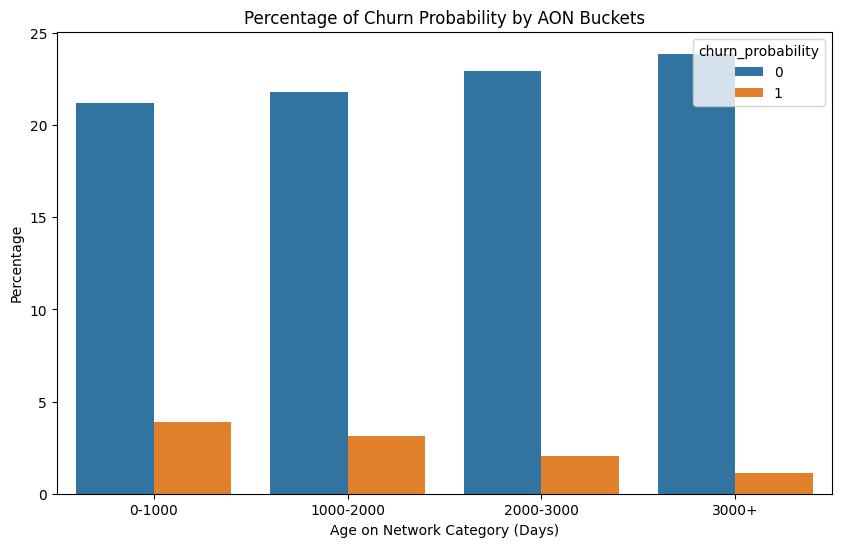

In [75]:
grouped_df = train_imputed_df.groupby(['churn_probability', 'aon_category']).count()['aon'] / train_imputed_df.shape[0] * 100
aon_percentage_df = grouped_df.reset_index(name='percentage')

plt.figure(figsize=(10, 6))
sns.barplot(x='aon_category', y='percentage', hue='churn_probability', data=aon_percentage_df)
plt.ylabel('Percentage')
plt.xlabel("Age on Network Category (Days)")
plt.title('Percentage of Churn Probability by AON Buckets')
plt.show()

In [76]:
grouped_df

churn_probability  aon_category
0                  0-1000          21.184588
                   1000-2000       21.798883
                   2000-3000       22.956042
                   3000+           23.871770
1                  0-1000           3.902913
                   1000-2000        3.142902
                   2000-3000        2.025743
                   3000+            1.117159
Name: aon, dtype: float64

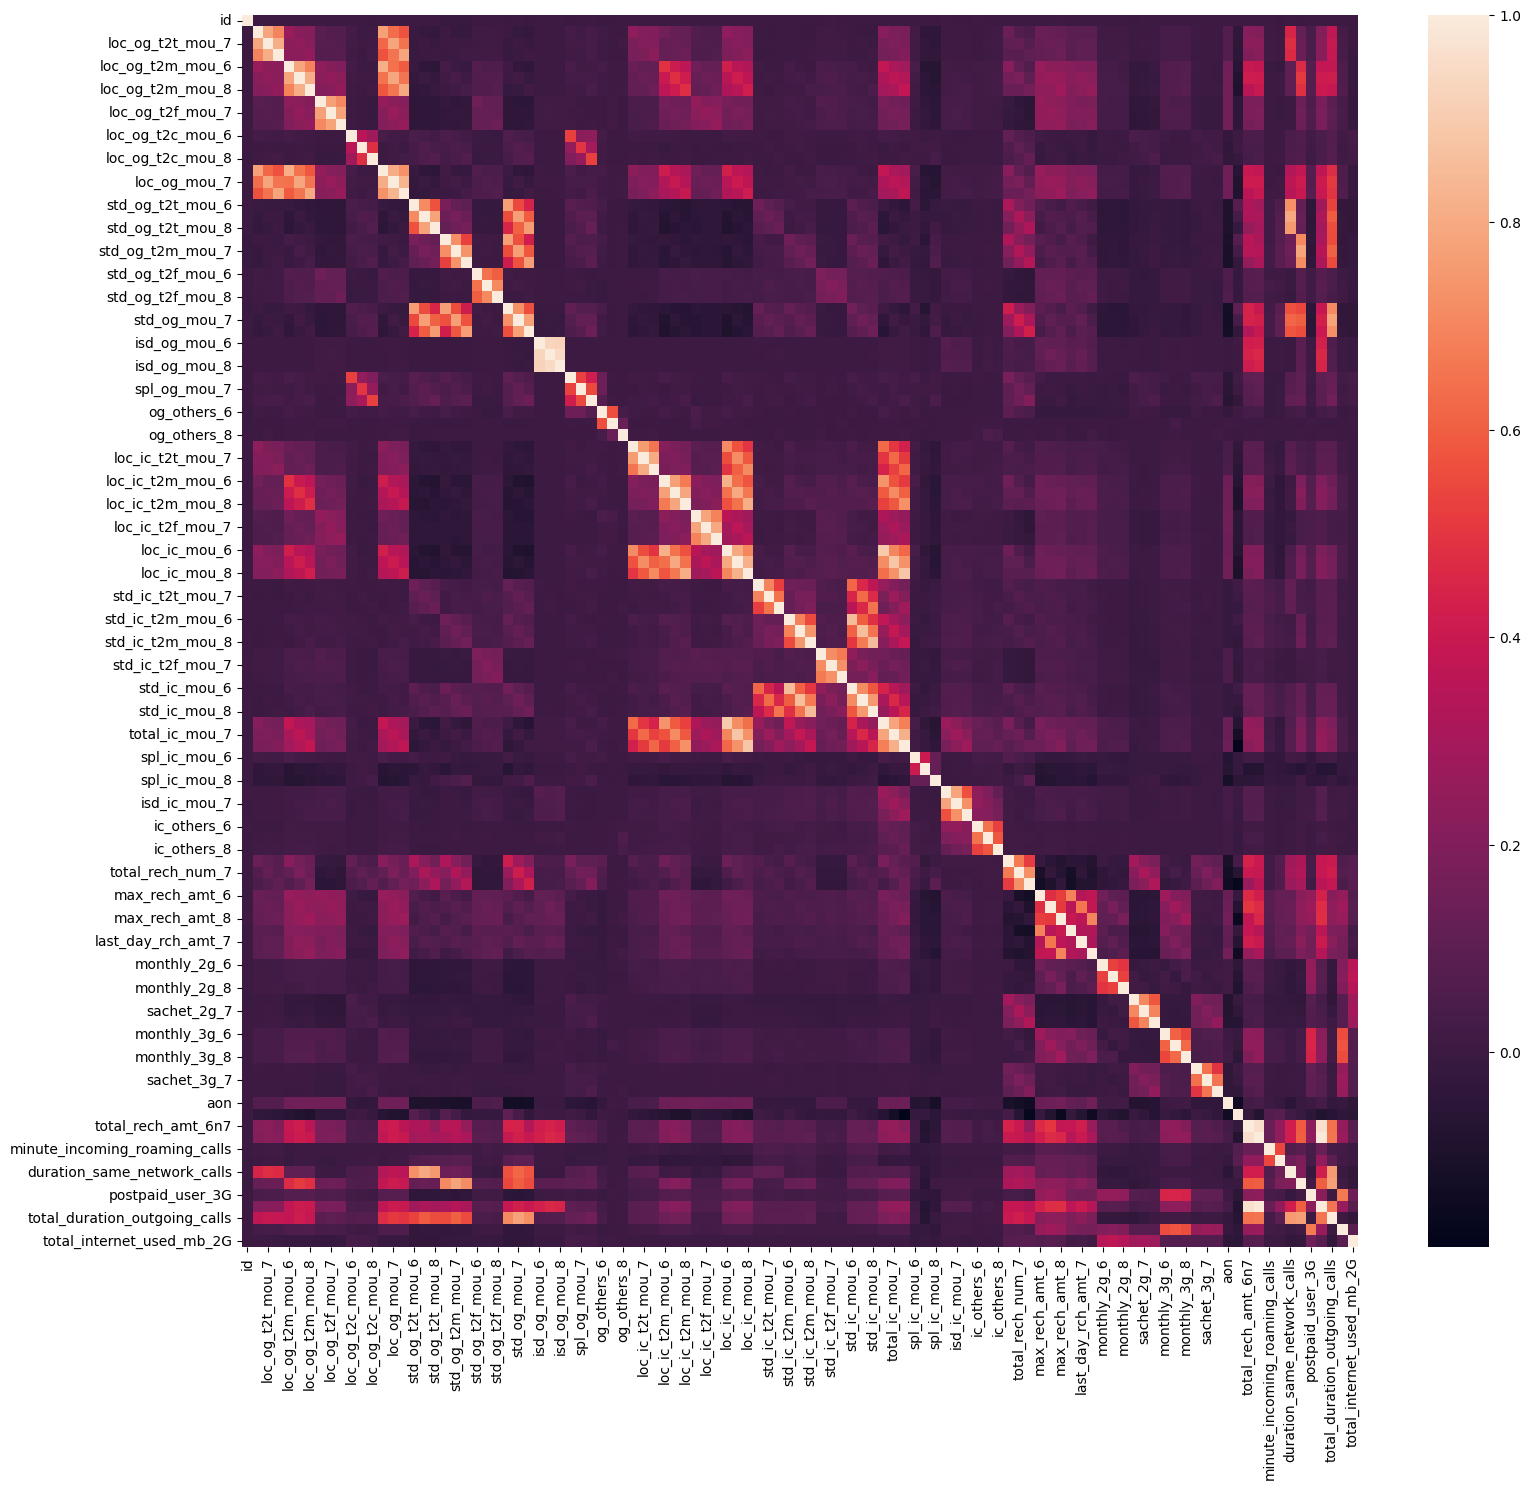

In [77]:
plt.figure(figsize=(18,16))
sns.heatmap(train_imputed_df.select_dtypes(include=['number']).corr())
plt.show()

# PCA

In [78]:
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train[top_n_feat])

In [79]:
pca = PCA(random_state=42)
pca.fit(X_train_scaled)

PCA(random_state=42)

In [80]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

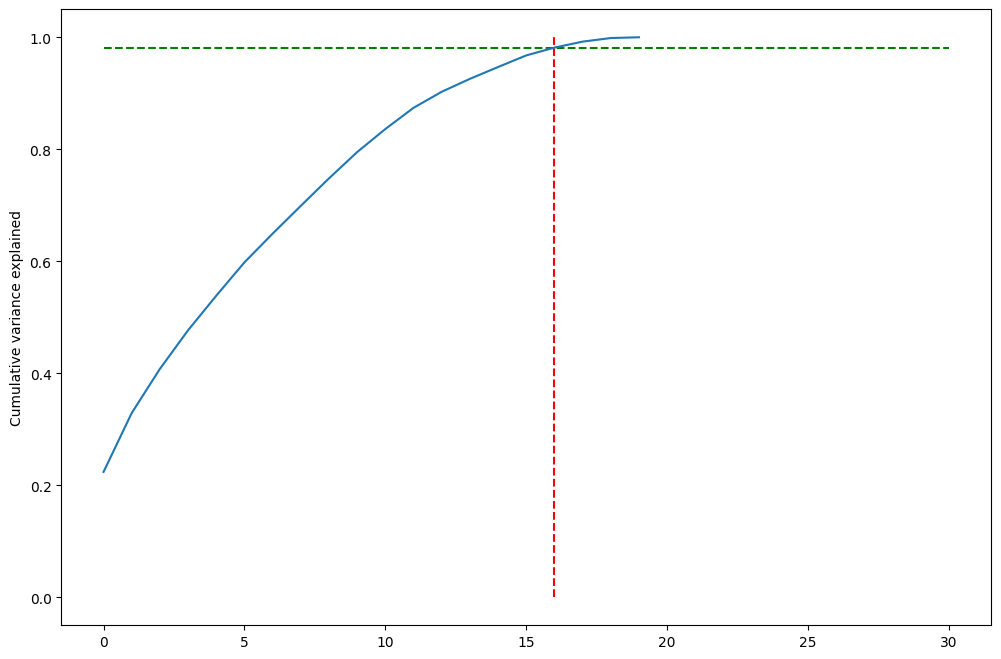

In [81]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=16, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.98, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

We were able to captuire 90% of variance in the dataset with 16 variables

In [82]:
from sklearn.decomposition import IncrementalPCA

In [83]:
pca_final = IncrementalPCA(n_components=13)
train_pca_df = pca_final.fit_transform(X_train_scaled)

#### Logistic Regression

In [84]:
lr = LogisticRegression(max_iter = 1000, tol=0.001, solver = 'sag')
lr.fit(train_pca_df, y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [85]:
lr.score(train_pca_df, y_train)

0.8990591644727444

### XGBoost Classifier

In [86]:
xgbc = XGBClassifier()
xgbc.fit(train_pca_df, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [87]:
xgbc.score(train_pca_df, y_train)

0.9607543011081858

### Hyperparameter Tuning

In [88]:
#Defining the parametergrid
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 300, 500]
}
xgb = XGBClassifier(use_label_encoder = False, eval_metric = "logloss")

In [89]:
f1_scorer = make_scorer(f1_score)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           scoring=f1_scorer, cv=5, n_jobs=-1)
grid_search.fit(train_pca_df, y_train)

print("Overall Better Performing Parameters : ",grid_search.best_params_)
print("Overall Better Performing Score : ",grid_search.best_score_)

Overall Better Performing Parameters :  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8}
Overall Better Performing Score :  0.6186534272885442


In [90]:
impute = SimpleImputer(strategy = 'constant', fill_value=0)
log_data = FunctionTransformer(np.log1p, validate=True)
scale = StandardScaler()
pca = IncrementalPCA(n_components=13)
xgb = XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=5,
    n_estimators=100,
    subsample=1.0,
    use_label_encoder=False,
    eval_metric='logloss'
)
pipeline = Pipeline([
    ('impute', impute),
    ('log_data', log_data),
    ('scale', scale),
    ('pca', pca),
    ('xgb', xgb)
])

In [91]:
pipeline.fit(X_train[top_n_feat], y_train)

Pipeline(steps=[('impute', SimpleImputer(fill_value=0, strategy='constant')),
                ('log_data',
                 FunctionTransformer(func=<ufunc 'log1p'>, validate=True)),
                ('scale', StandardScaler()),
                ('pca', IncrementalPCA(n_components=13)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=No...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [92]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipeline, X_train[top_n_feat], y_train, cv=5, scoring='accuracy')

print(f"Cross Validation Accuracy Score : {cv_scores.mean()}")

Cross Validation Accuracy Score : 0.9392641252439338


In [93]:
cv_scores

array([0.94010204, 0.93857143, 0.93816327, 0.93734694, 0.94213695])

In [94]:
train_score = pipeline.score(X_train[top_n_feat], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9436519112634951


In [95]:
test_score = pipeline.score(X_test[top_n_feat], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.9393809523809524


In [96]:
confusion_matrix(y_train, pipeline.predict(X_train[top_n_feat]))

array([[43171,   851],
       [ 1910,  3067]])

In [97]:
precision_score(y_test, pipeline.predict(X_test[top_n_feat]))

0.7581967213114754

In [98]:
recall_score(y_test, pipeline.predict(X_test[top_n_feat]))

0.6009280742459396

In [99]:
from sklearn.metrics import f1_score

f1_score(y_test, pipeline.predict(X_test[top_n_feat]))

0.6704633704374838

# Preprocessing of Test Set

In [101]:
test["minute_incoming_roaming_calls"] = test["roam_ic_mou_6"] + test["roam_ic_mou_7"] + test["roam_ic_mou_8"]
test.drop(["roam_ic_mou_6","roam_ic_mou_7","roam_ic_mou_8"], axis = 1, inplace = True)

test["minute_outgoing_roaming_calls"] = test["roam_og_mou_6"] + test["roam_og_mou_7"] +test["roam_og_mou_8"]
test.drop(["roam_og_mou_6","roam_og_mou_7","roam_og_mou_8"], axis = 1, inplace = True)

test["duration_same_network_calls"] = test["onnet_mou_6"] +test["onnet_mou_7"] + test["onnet_mou_8"]
test.drop(["onnet_mou_6","onnet_mou_7","onnet_mou_8"], axis = 1, inplace = True)

test["duration_other_network_calls"] = test["offnet_mou_6"] +test["offnet_mou_7"] + test["offnet_mou_8"]
test.drop(["offnet_mou_6","offnet_mou_7","offnet_mou_8"], axis = 1, inplace = True)

test["postpaid_user_3G"] = test["aug_vbc_3g"] + test["jul_vbc_3g"] + test["jun_vbc_3g"]
test.drop(["aug_vbc_3g","jul_vbc_3g","jun_vbc_3g"], axis=1, inplace=True)

test["total_rech_amt"] = test["total_rech_amt_6"] + test["total_rech_amt_7"] +test["total_rech_amt_8"]
test.drop(["total_rech_amt_8"], axis = 1, inplace = True)

test["total_duration_outgoing_calls"] = test["total_og_mou_6"] + test["total_og_mou_7"] + test["total_og_mou_8"]
test.drop(["total_og_mou_6","total_og_mou_7","total_og_mou_8"], axis = 1, inplace = True)

test["total_intenet_used_mb_3G"] = test["vol_3g_mb_6"] + test["vol_3g_mb_7"] + test["vol_3g_mb_8"]
test.drop(["vol_3g_mb_6","vol_3g_mb_7","vol_3g_mb_8"], axis = 1 , inplace=True)

test['total_internet_used_mb_2G'] = test['vol_2g_mb_6'] + test['vol_2g_mb_7'] + test['vol_2g_mb_8']
test.drop(['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8'], axis = 1, inplace = True)

In [102]:
submission_data = test[top_n_feat]

In [103]:
test['churn_probability'] = pipeline.predict(submission_data)

In [104]:
output = test[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0


In [105]:
output['churn_probability'].value_counts()

churn_probability
0    28422
1     1578
Name: count, dtype: int64

In [107]:
output.to_csv('submission.csv',index=False)

# Model For Explainability

In [108]:
lr_model = LogisticRegression()

In [109]:
lrpipe = Pipeline(steps = [('imputezero',impute),
                         ('logtran',log_data),
                         ('scaling',scale),
                         ('model',lr_model)])

In [110]:
lrpipe.fit(X_train[top_n_feat],y_train)

Pipeline(steps=[('imputezero',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('logtran',
                 FunctionTransformer(func=<ufunc 'log1p'>, validate=True)),
                ('scaling', StandardScaler()),
                ('model', LogisticRegression())])

In [111]:
y_pred = lrpipe.predict(X_test[top_n_feat])

In [112]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     18845
           1       0.76      0.60      0.67      2155

    accuracy                           0.94     21000
   macro avg       0.86      0.79      0.82     21000
weighted avg       0.94      0.94      0.94     21000



In [113]:
# Extracting the Logistic regression model from pipeline
lr_model = lrpipe.named_steps['model']

# Get the coefficients and intercept
coefficients = lr_model.coef_[0]
intercept = lr_model.intercept_[0]

In [114]:
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"Feature_{i}" for i in range(X_train.shape[1])]

In [115]:
# Construct the equation
equation = f"log(p/(1-p)) = {intercept:.4f}"
for coef, feature in zip(coefficients, feature_names):
    if coef >= 0:
        equation += f" + {coef:.4f} * {feature}"
    else:
        equation += f" - {abs(coef):.4f} * {feature}"

print("\nLogistic Regression Equation:")
print(equation)


Logistic Regression Equation:
log(p/(1-p)) = -3.4515 - 1.2916 * id + 0.3133 * loc_og_t2t_mou_6 - 0.5478 * loc_og_t2t_mou_7 + 0.4318 * loc_og_t2t_mou_8 - 0.0133 * loc_og_t2m_mou_6 - 0.5490 * loc_og_t2m_mou_7 - 0.0276 * loc_og_t2m_mou_8 - 0.0691 * loc_og_t2f_mou_6 - 0.3049 * loc_og_t2f_mou_7 + 0.1223 * loc_og_t2f_mou_8 - 0.0543 * loc_og_t2c_mou_6 - 0.3098 * loc_og_t2c_mou_7 + 0.1294 * loc_og_t2c_mou_8 - 0.1545 * loc_og_mou_6 + 0.1280 * loc_og_mou_7 - 0.0370 * loc_og_mou_8 + 0.2866 * std_og_t2t_mou_6 + 0.1491 * std_og_t2t_mou_7 - 0.2428 * std_og_t2t_mou_8 + 0.0405 * std_og_t2m_mou_6


In [116]:
xgb_model = XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=5,
    n_estimators=100,
    subsample=1.0,
    use_label_encoder=False,
    eval_metric='logloss'
)

In [117]:
xgbpipe = Pipeline(steps = [('imputezero',impute),
                         ('logtran',log_data),
                         ('scaling',scale),
                         ('model',xgb_model)])

In [118]:
xgbpipe.fit(X_train[top_n_feat],y_train)

Pipeline(steps=[('imputezero',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('logtran',
                 FunctionTransformer(func=<ufunc 'log1p'>, validate=True)),
                ('scaling', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               ena...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [119]:
y_pred_xgb = xgbpipe.predict(X_test[top_n_feat])

In [120]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     18845
           1       0.76      0.63      0.69      2155

    accuracy                           0.94     21000
   macro avg       0.86      0.80      0.83     21000
weighted avg       0.94      0.94      0.94     21000



In [121]:
xgb_model_from_pipe = xgbpipe.named_steps['model']

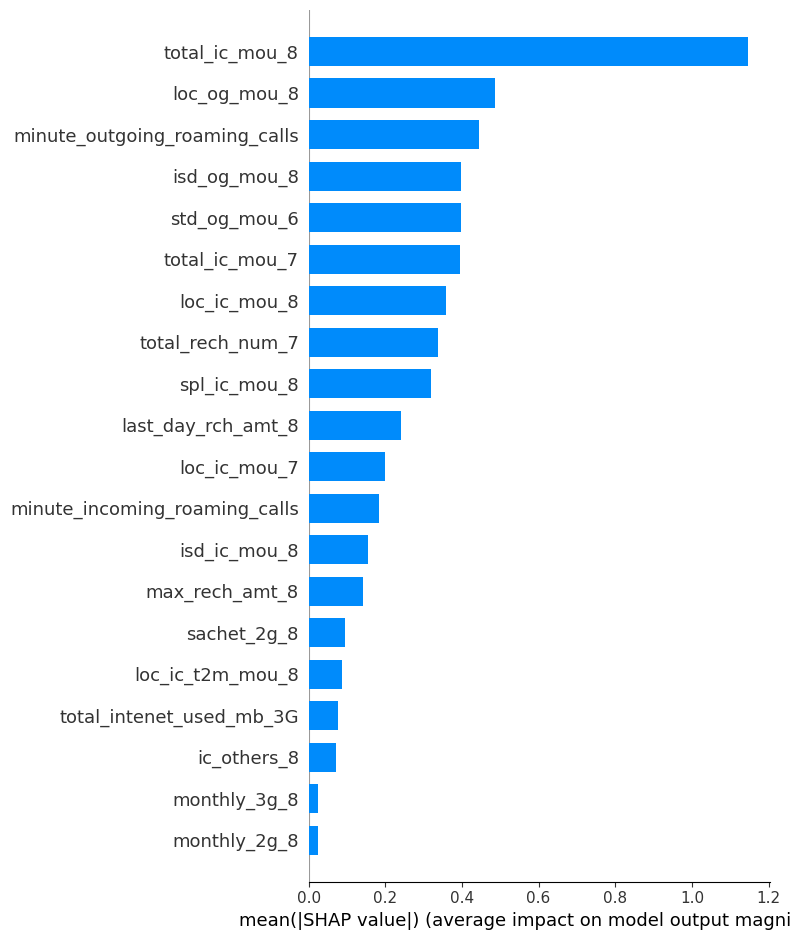

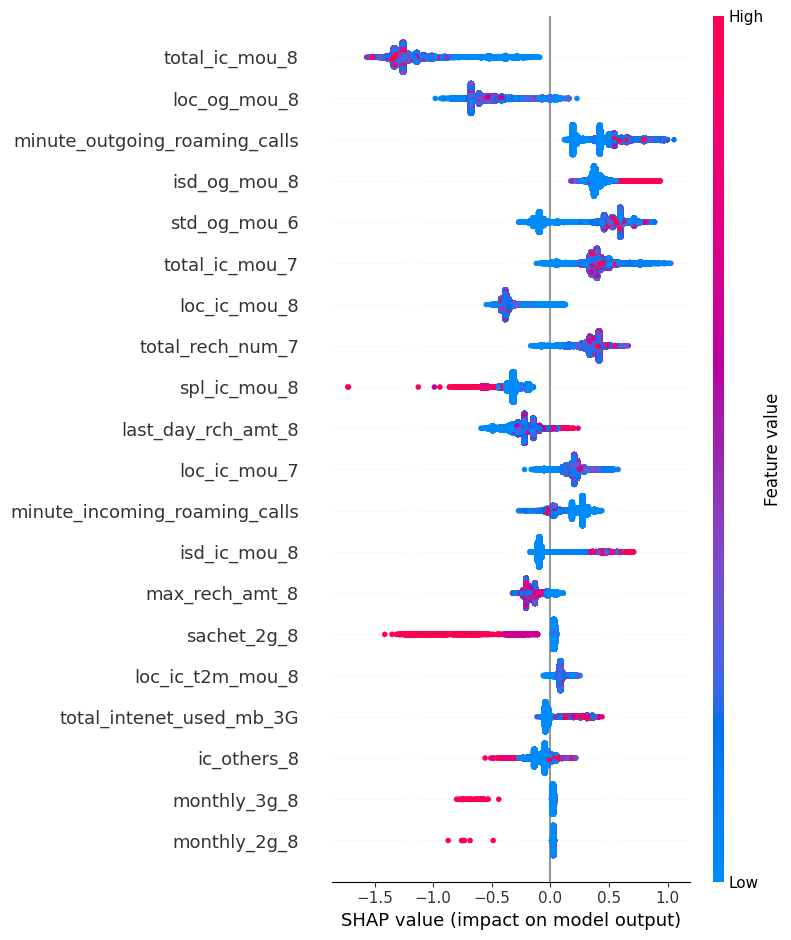

In [122]:
import shap

explainer = shap.TreeExplainer(xgb_model_from_pipe)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train[top_n_feat])

shap.summary_plot(shap_values, X_train[top_n_feat], plot_type="bar")

# Show the impact of features for individual predictions
shap.summary_plot(shap_values, X_train[top_n_feat])

# Conclusion
* Roaming outgoing calls mou & STD calls outgoing mou are on of the biggest factors predicting churn.
* Incoming local and roaming calls also have shown the pattern in customer churn.
* Mostly the last two months of the data have shown the patterns to identify churn.
* Average recharge amount also has shown a significant impact on the churn.

# Business Suggestion
* Try to maximize the offers on data packs which will help to retain customers and will have less churn.